In [6]:
import pennylane as qml
from gate_opt_utils_2 import *
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils import *
from quantum_circuit_optimization import *

In [2]:
[ds] = qml.data.load("ketgpt")

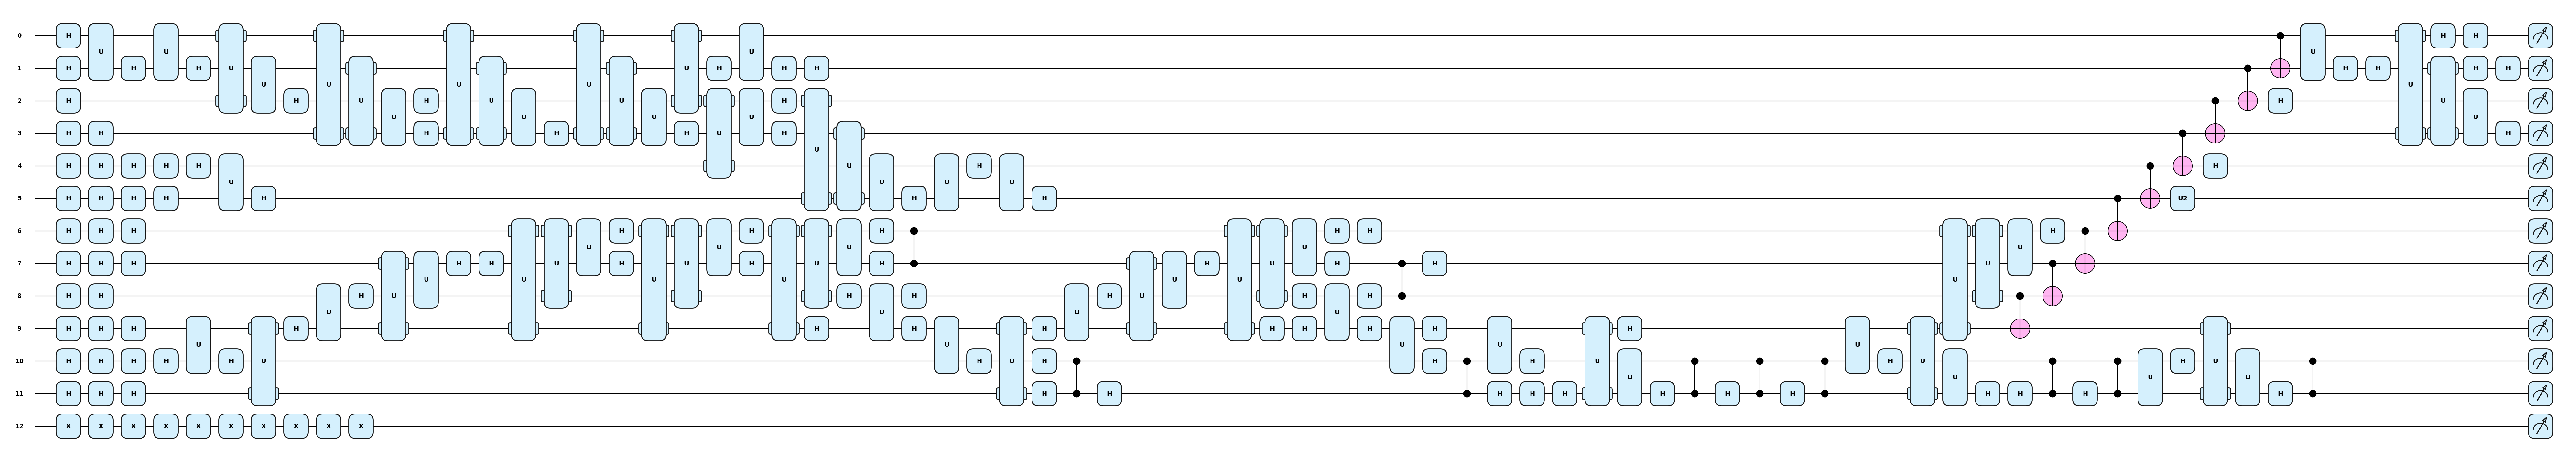

               0
num_qubit     13
num_gate     199
num_1q_gate  116
num_2q_gate   19
unitary       64
depth         66
None


In [3]:
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67
None


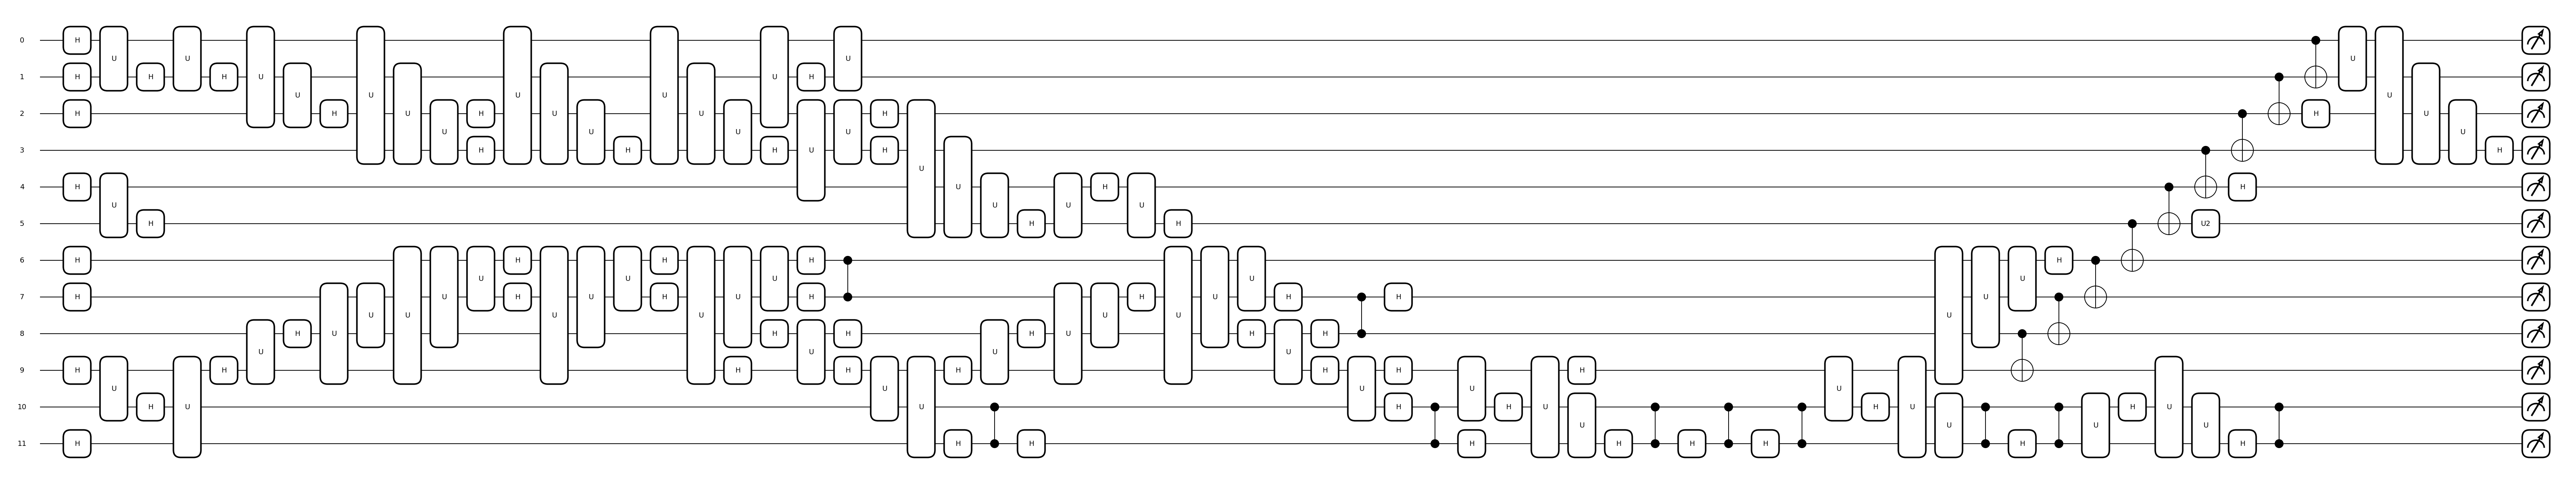

In [7]:
qnode = optimization_lev_1(ds, circuit, seed=0)

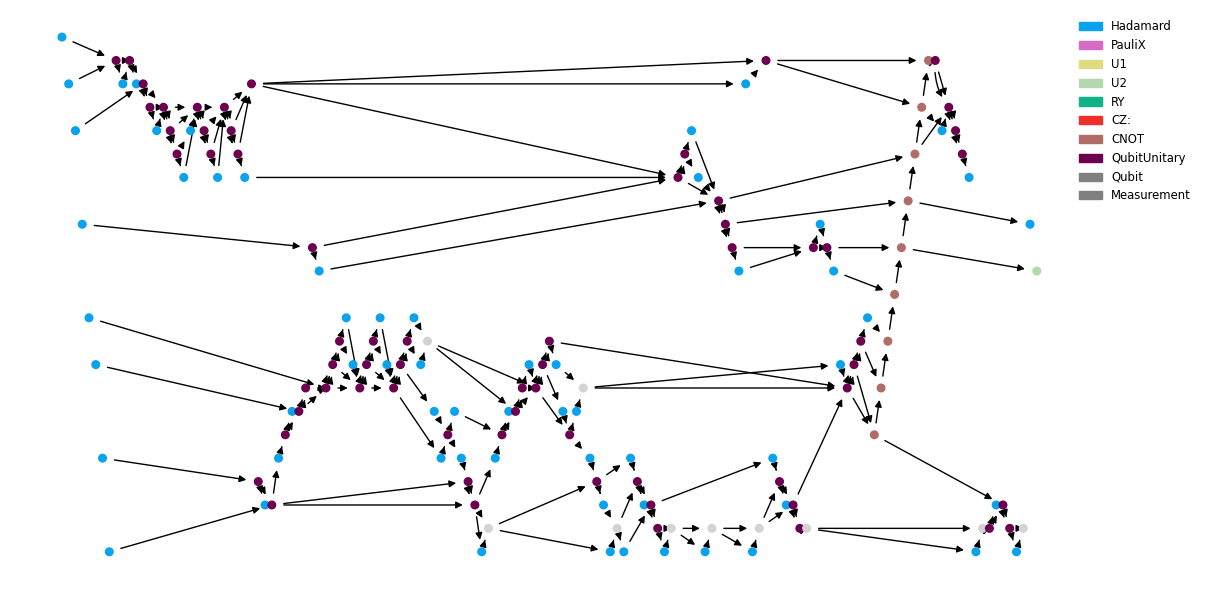

In [8]:
pg = Penny_to_Graph(qnode)
pg.show_graph(pg.G)

In [9]:
# methods combined
def remove_nodes(G_input, node_to_remove, by_label=False, pos_input=None, node_colors_input=None):
    if pos_input is None:
        pos_input = {}
    if node_colors_input is None:
        node_colors_input = {}

    # determine mode
    if by_label:
        nodes_to_remove = [n for n, attr in G_input.nodes(data=True) if attr.get('label') in node_to_remove]
    else:
        nodes_to_remove = [n for n in node_to_remove if n in G_input]

    G = G_input.copy()
    G.remove_nodes_from(nodes_to_remove)

    # Update pos and node_colors
    pos = {n: pos_input[n] for n in G.nodes if n in pos_input}
    if isinstance(node_colors_input, dict):
        node_colors = [node_colors_input[n] for n in G.nodes if n in node_colors_input]
    else:
        node_to_color = {n: node_colors_input[i] for i, n in enumerate(G_input.nodes)}
        node_colors = [node_to_color[n] for n in G.nodes if n in node_to_color]

    return [G, pos, node_colors]

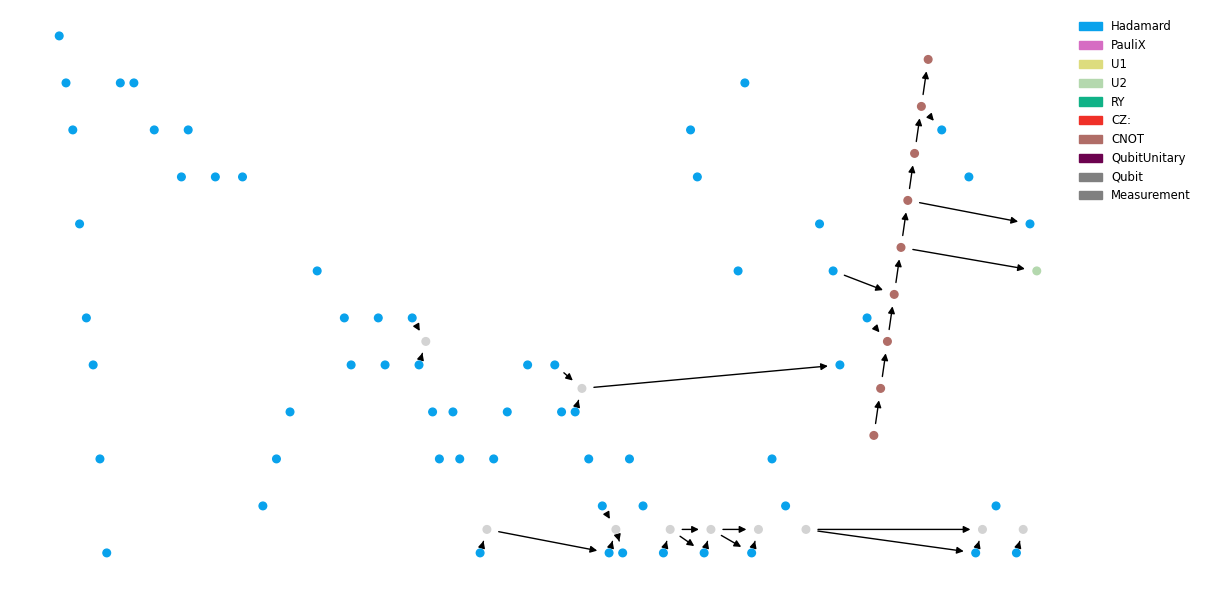

In [10]:
arr = remove_nodes(pg.G, node_to_remove=['QubitUnitary'], by_label=True, pos_input=pg.pos, node_colors_input=pg.node_colors)

pg.set_G(arr[0])
pg.set_pos(arr[1])
pg.set_node_colors(arr[2])
pg.show_graph(pg.G)

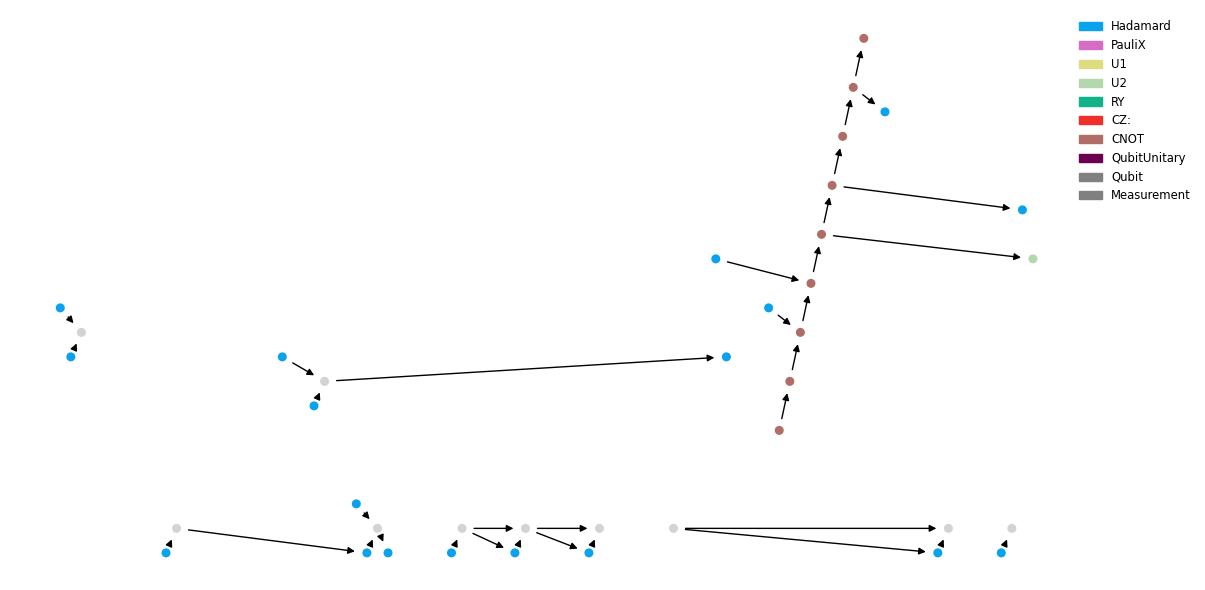

In [11]:
arr = remove_nodes(pg.G, node_to_remove=list(nx.isolates(pg.G)), by_label=False, pos_input=pg.pos, node_colors_input=pg.node_colors)

pg.set_G(arr[0])
pg.set_pos(arr[1])
pg.set_node_colors(arr[2])
pg.show_graph(pg.G)

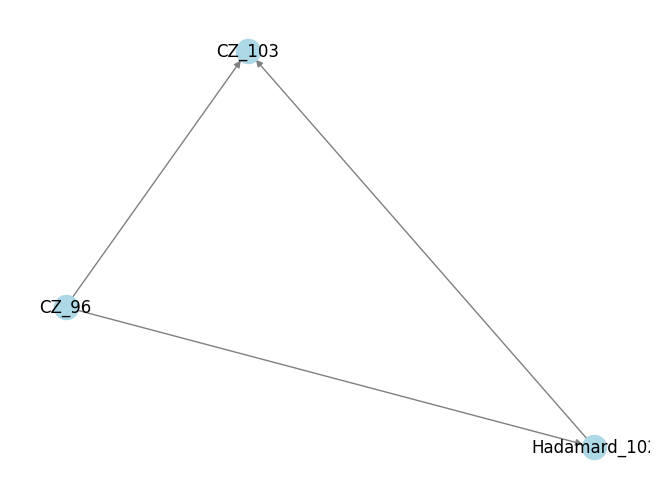

In [12]:
gate_2q = [n for n, attr in pg.G.nodes(data=True) if len(attr['wires'])==2]
radius = 10
# for g in gate_2q:
#     subG = nx.ego_graph(pg.G, g, radius=radius)
#     nx.draw(subG, with_labels=True, node_color='lightblue', edge_color='gray')
#     plt.show()
center_node = gate_2q[5]
subG = nx.ego_graph(pg.G, center_node, radius=radius)
nx.draw(subG, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [13]:
# Get connected components
components = list(nx.connected_components(pg.G.to_undirected()))

# Print each component
for i, comp in enumerate(components):
    print(f"comp {i+1}: {comp}")

comp 1: {'Hadamard_53', 'CZ_54', 'Hadamard_52'}
comp 2: {'CZ_82', 'Hadamard_81', 'Hadamard_62', 'CZ_63', 'Hadamard_83', 'Hadamard_80'}
comp 3: {'CZ_77', 'Hadamard_73', 'Hadamard_76', 'Hadamard_115'}
comp 4: {'Hadamard_102', 'Hadamard_95', 'CZ_96', 'Hadamard_89', 'CZ_103', 'CZ_90'}
comp 5: {'Hadamard_135', 'CZ_110', 'CZ_136'}
comp 6: {'Hadamard_114', 'CNOT_128', 'CNOT_123', 'CNOT_126', 'CNOT_121', 'Hadamard_119', 'U2_144', 'CNOT_120', 'CNOT_125', 'Hadamard_143', 'CNOT_122', 'Hadamard_130', 'CNOT_127', 'CNOT_124'}
comp 7: {'CZ_142', 'Hadamard_141'}


In [14]:
import networkx as nx

# Step 1: Get connected components from undirected version
components = list(nx.connected_components(pg.G.to_undirected()))

# Step 2–4: Process each component
radius = 1  # You can adjust this as needed
subgraphs = []

for comp in components:
    # Step 2: Filter nodes in this component that meet the condition
    candidate_nodes = [
        n for n in comp
        if 'wires' in pg.G.nodes[n] and len(pg.G.nodes[n]['wires']) == 2
    ]

    # Step 3: If any candidate found, take the first as center
    if candidate_nodes:
        center_node = candidate_nodes[0]

        # Step 4: Get ego graph centered on that node
        subG = nx.ego_graph(pg.G, center_node, radius=radius)
        subgraphs.append(subG)

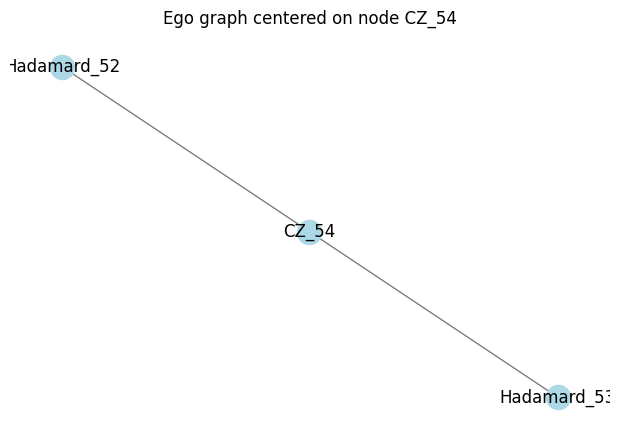

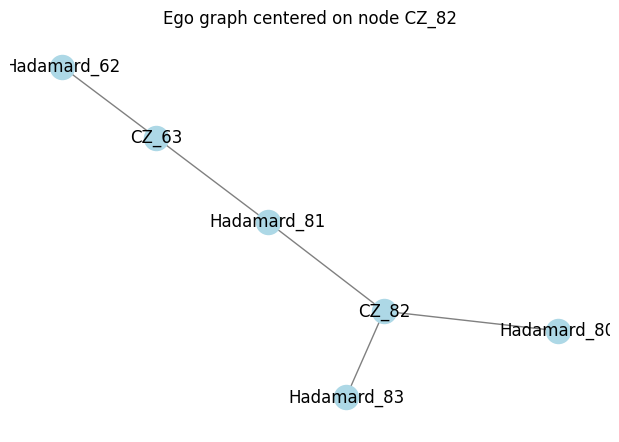

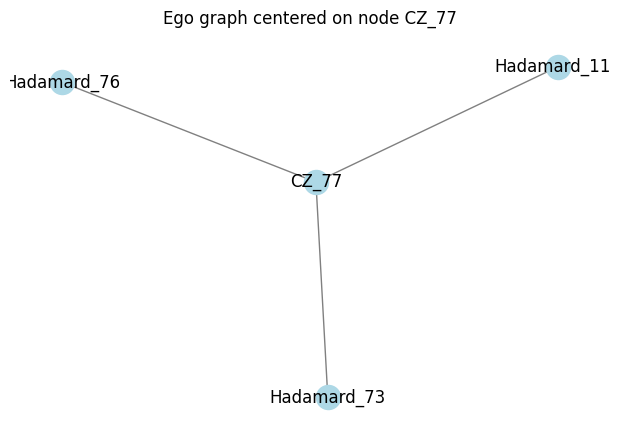

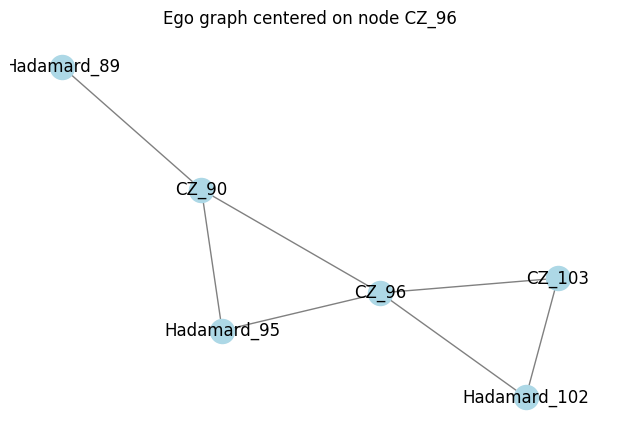

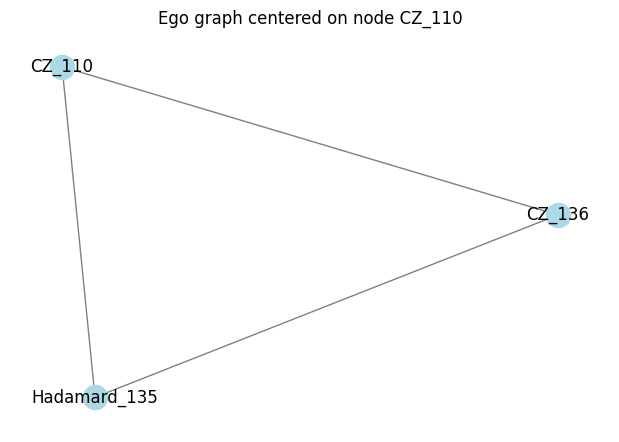

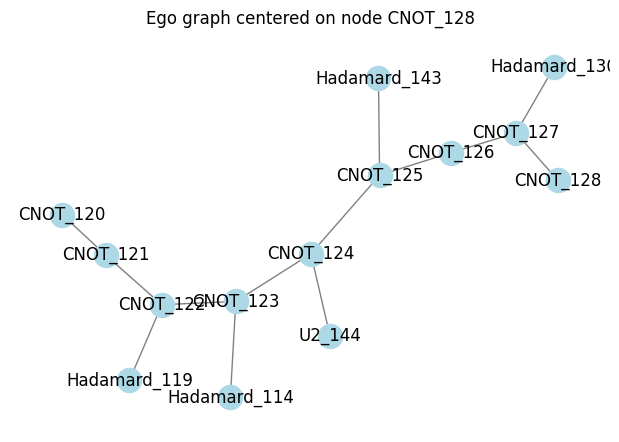

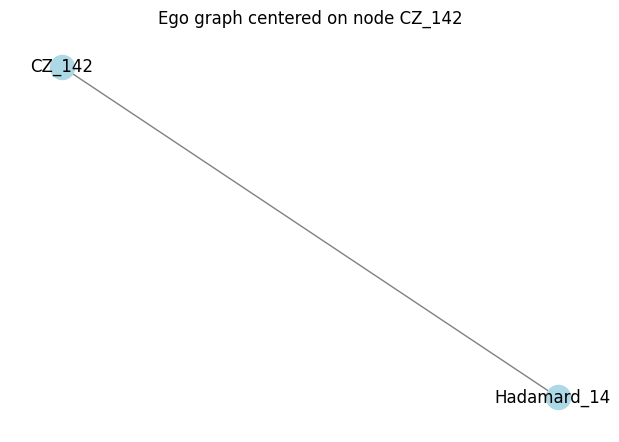

In [15]:
# graph needs transforming into an undirected on for these procedures!
components = list(nx.connected_components(pg.G.to_undirected()))
radius = 10 
subgraphs = []

for comp in components:
    candidate_nodes = [ # search for two-qubit gates
        n for n in comp
        if 'wires' in pg.G.nodes[n] and len(pg.G.nodes[n]['wires']) == 2
    ]

    if candidate_nodes: # draw ego graphs
        center_node = candidate_nodes[0]
        subG = nx.ego_graph(pg.G.to_undirected(), center_node, radius=radius)
        subgraphs.append(subG)

        plt.figure(figsize=(6, 4))
        nx.draw(subG, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title(f"Ego graph centered on node {center_node}")
        plt.show()

CZ_54


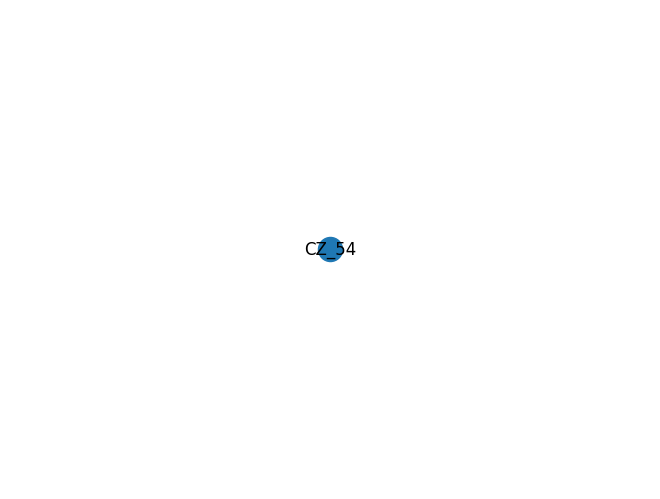

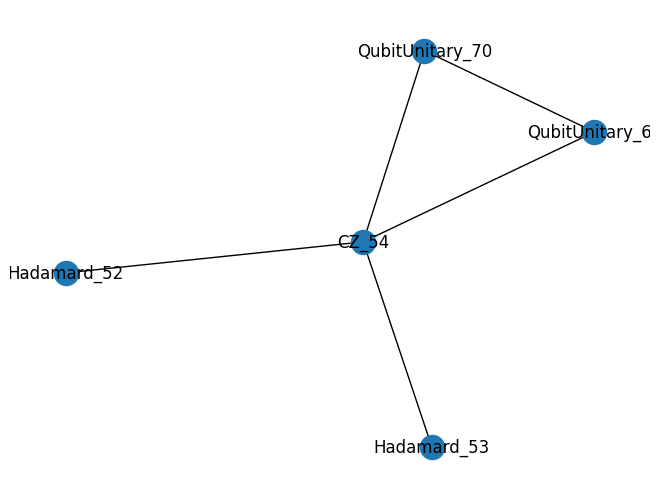

In [24]:
# get ego graphs of two-qubit gates without removing any
# examine how the gate changes with radius
# stop increasing the radius when neighbors' wires deviated from its own
pg = Penny_to_Graph(qnode)

gate_2q = [n for n, attr in pg.G.nodes(data=True) if attr['num_q']==2]

radius = 0

# test center node
center_node = gate_2q[13]
print(center_node)

for i in range(2):
    subG = nx.ego_graph(pg.G.to_undirected(), center_node, radius=radius)
    nx.draw(subG, with_labels=True)
    plt.show()
    radius += 1

In [25]:
pg.G.nodes[center_node]['wires']

[6, 7]

In [26]:
bool_list = []
wires = pg.G.nodes[center_node]['wires']
for node, attr in subG.nodes(data=True):
    print(attr['wires'], set(attr['wires']).issubset(wires))
    bool_list.append(set(attr['wires']).issubset(wires))

[7, 8, 9] False
[6, 7] True
[6] True
[7] True
[6, 7, 8, 9] False


In [27]:
bool_list.count(False)

2

=== limitation : equal search in all directions

In [28]:
# core routine to find subgraphs
subgraphs = []

for center in [n for n, attr in pg.G.nodes(data=True) if attr['num_q']==2]:
    radius = 0
    wires = pg.G.nodes[center]['wires']
    # examine wires of its neighbors
    while True:
        bool_list = []
        subG = nx.ego_graph(pg.G.to_undirected(), center, radius=radius) # issue : equal exansion
        for node, attr in subG.nodes(data=True):
            bool_list.append(set(attr['wires']).issubset(wires))

        # check the stopping creterion
        if bool_list.count(False) > 1:
            subgraphs.append({'center':center, 'subG':subG})
            break
        else:
            radius += 1

QubitUnitary_8


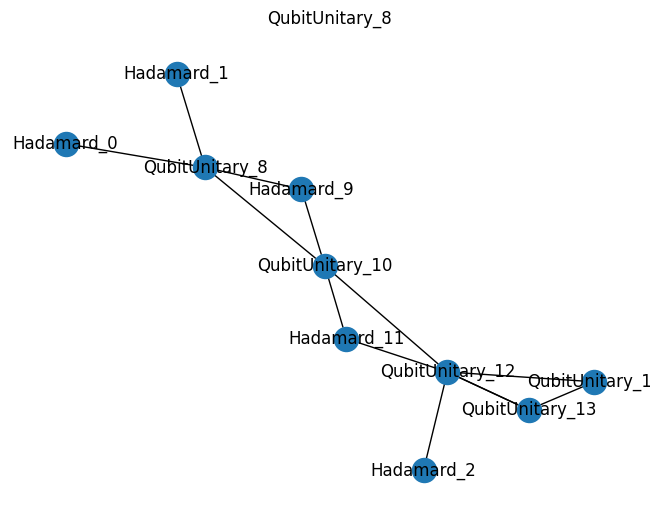

In [29]:
print(subgraphs[0]['center'])
nx.draw(subgraphs[0]['subG'], with_labels=True)
plt.title(subgraphs[0]['center'])
plt.show()

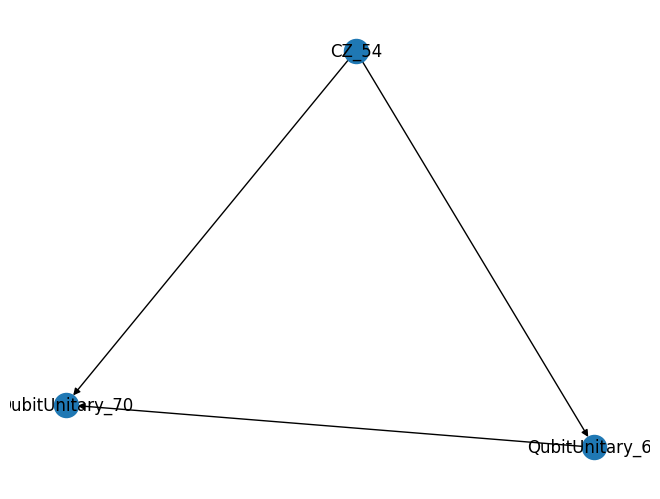

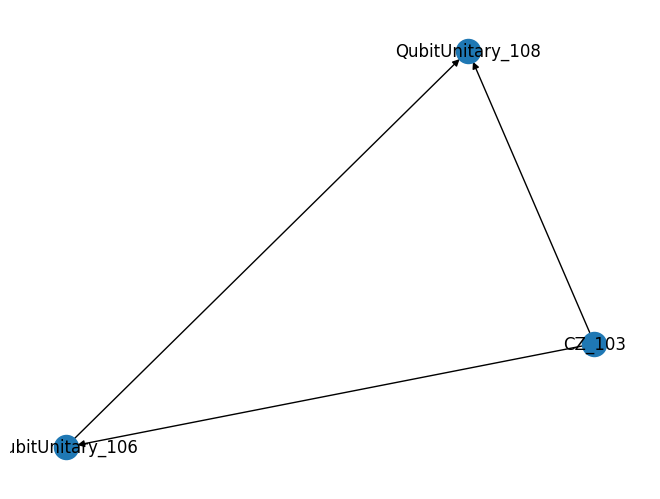

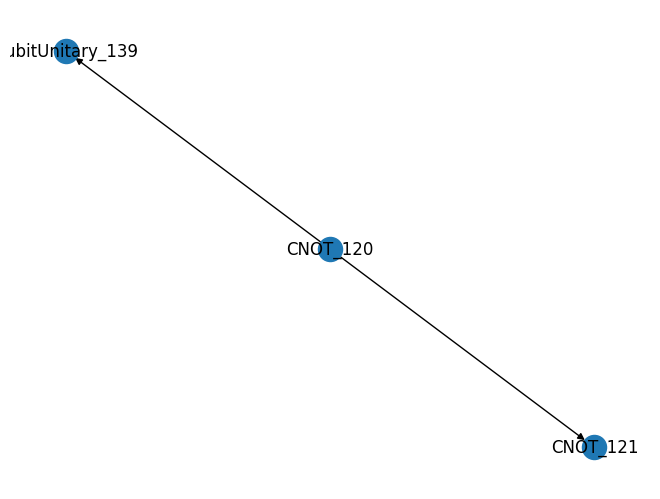

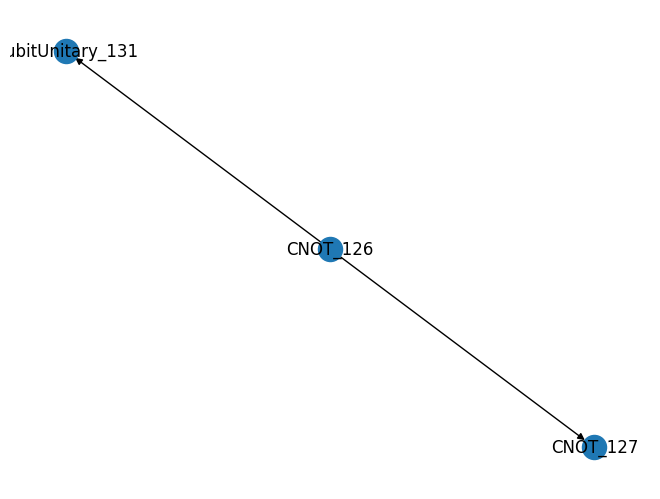

In [58]:
for i, dic in enumerate(subgraphs):
    center = dic['center']
    subG = dic['subG']
    nx.draw(subG, with_labels=True)
    plt.show()

=== Search prototype

In [ ]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7])
G.add_edges_from([(1, 3), (2, 3), (3, 4), (3, 5), (2, 6), (5, 7)])

center = 3
directions = {}  # Each neighbor gets its own path list

for neighbor in G.neighbors(center): # for each direction
    # insert a stopping criterion
    visited = {center, neighbor}
    stack = [neighbor]
    path = [neighbor]

    while stack:
        node = stack.pop()
        for adj in G.neighbors(node):
            if adj not in visited:
                visited.add(adj)
                stack.append(adj)
                path.append(adj)

    directions[neighbor] = path

for start, path in directions.items():
    print(f"Direction from {center} → {start}: {path}")

Direction from 3 → 1: [1]
Direction from 3 → 2: [2, 6]
Direction from 3 → 4: [4]
Direction from 3 → 5: [5, 7]


In [31]:
directions

{1: [1], 2: [2, 6], 4: [4], 5: [5, 7]}

In [59]:
subgraphs = []

for center in [n for n, attr in pg.G.nodes(data=True) if attr['num_q'] == 2]:
    wires = pg.G.nodes[center]['wires']
    directions = []

    for neighbor in pg.G.neighbors(center):
        visited = {center, neighbor}
        stack = [(neighbor, 1)]  # (node, depth)
        path = [neighbor]

        while stack:
            node, depth = stack.pop()

            # Stopping criterion: wires must be subset of center's wires
            node_wires = pg.G.nodes[node]['wires']
            if not set(node_wires).issubset(wires):
                break

            path.append(node)

            for adj in pg.G.neighbors(node):
                if adj not in visited:
                    visited.add(adj)
                    stack.append((adj, depth + 1))

        directions.append(path)

    bad_paths = [path for path in directions if any(
        not set(pg.G.nodes[n]['wires']).issubset(wires) for n in path)]

    if len(bad_paths) > 1:
        nodes_in_subgraph = set([center])
        for path in directions:
            nodes_in_subgraph.update(path)

        subG = pg.G.subgraph(nodes_in_subgraph).copy()
        subgraphs.append({'center': center, 'subG': subG})

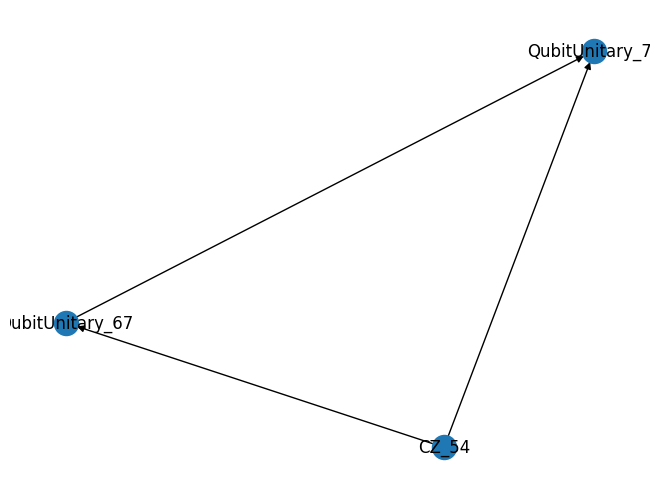

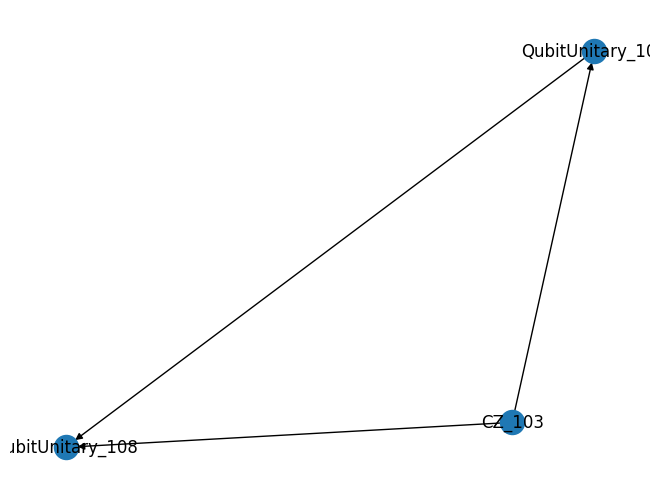

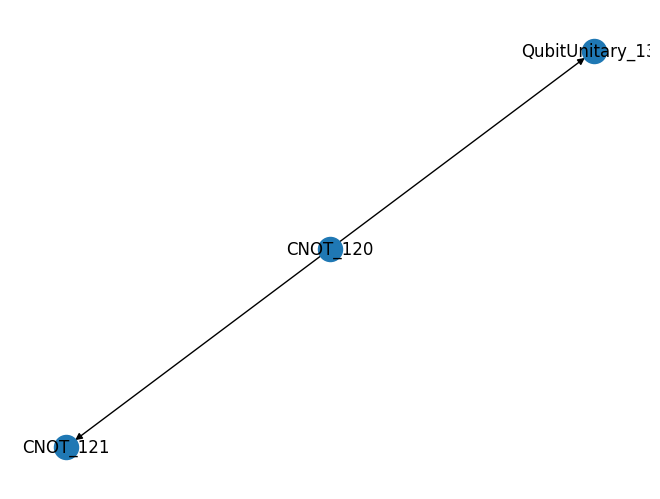

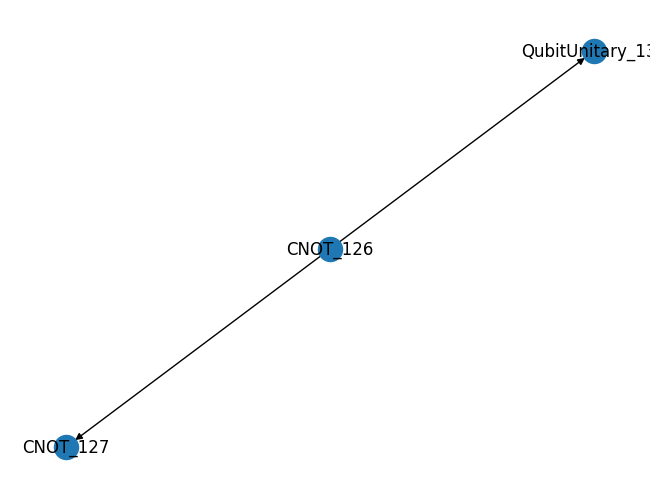

In [60]:
for dic in subgraphs:
    nx.draw(dic['subG'], with_labels=True)
    plt.show()